In [156]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import prettytable 
prettytable.DEFAULT = 'DEFAULT'
import sqlite3
conn = sqlite3.connect('mydb.db')
%load_ext sql
import requests 
from sklearn.preprocessing import MinMaxScaler
%sql sqlite:///mydb.db



The sql extension is already loaded. To reload it, use:
  %reload_ext sql


#### To create the tables I needed, I used publicly available data sources for historical information, players, and champions.  
#### I also worked with a large Kaggle move dataset, which I managed, filtered, and reorganized using a DB2 account provided by the course.

In [8]:
df_move=pd.read_csv('chess_move.csv')
df_match=pd.read_csv('joined_chess_data.csv')

#### I've started from 2 table previously managed 

In [10]:
#table 1
df_move.head()

,ANNO,WHITEMOVE,WHITECOUNT,BLACKMOVE,BLACKCOUNT
0,1886,e2e4,11,e7e5,11
1,1886,d2d4,9,d7d5,9
2,1889,e2e4,9,e7e5,9
3,1889,g1f3,6,d7d5,6
4,1889,g1f3,1,f7f5,1


#### To check if there are any inconsistencies in the data I've created, for each combination there is a white count and a black count, which should be the same.


In [12]:
if (df_move['WHITECOUNT'] == df_move['BLACKCOUNT']).all():
    print("The data is internally consistent")
else:
    print("There are inconsistencies in the data")

The data is internally consistent


In [26]:
df_match=df_match.drop_duplicates()
df_match.head()

,YEAR,MATCH,player1,player2,champ,win
0,1886,Steinitz vs. Zukertort,Steinitz,Zukertort,Wilhelm Steinitz,1886
1,1889,Steinitz vs. Chigorin,Steinitz,Chigorin,Wilhelm Steinitz,1889
2,1890,Steinitz vs. Gunsburg,Steinitz,Gunsburg,Wilhelm Steinitz,1890
3,1892,Steinitz vs. Chigorin II,Steinitz,Chigorin II,Wilhelm Steinitz,1892
4,1894,Steinitz vs. Lasker,Steinitz,Lasker,Emanuel Lasker,1894


In [28]:
df_move.to_sql('Moves', conn, if_exists='replace', index=False)
df_match.to_sql('Matches', conn, if_exists='replace', index=False)

53

#### Creation of table for a complessive point of view

In [ ]:
%sql CREATE TABLE MOVE_MATCH (YEAR YEAR, player1 TEXT, player2 TEXT, whitemove CHAR(4), black_move CHAR(4), champ TEXT, COUNT INTEGER)

In [ ]:
%%sql INSERT INTO MOVE_MATCH (YEAR, player1, player2, whitemove, black_move, champ, COUNT)
SELECT Moves.ANNO, Matches.player1, Matches.player2, Moves.WHITEMOVE, Moves.BLACKMOVE, Matches.champ, Moves.WHITECOUNT
FROM Moves
LEFT JOIN Matches ON Moves.ANNO = Matches.Year;

In [ ]:
%sql select * from MOVE_MATCH

#### During 1997 and 1998, the Chess World Championship did not organize a traditional face-to-face match. Instead, it was decided through a knockout elimination format with 331 matches, as confirmed by an independent online source.

In [23]:
#check
%sql SELECT SUM(COUNT)FROM MOVE_MATCH WHERE YEAR>=1997 AND YEAR<=1998

 * sqlite:///mydb.db
Done.


SUM(COUNT)
331


### Complete classification of white moves with frequencies

In [64]:
%%sql SELECT whitemove, SUM(COUNT) AS total_times_played FROM MOVE_MATCH
GROUP BY whitemove
ORDER BY total_times_played DESC

 * sqlite:///mydb.db
Done.


whitemove,total_times_played
e2e4,1701
d2d4,1450
g1f3,288
c2c4,267
g2g3,24
b2b3,3
f2f4,1
b1c3,1


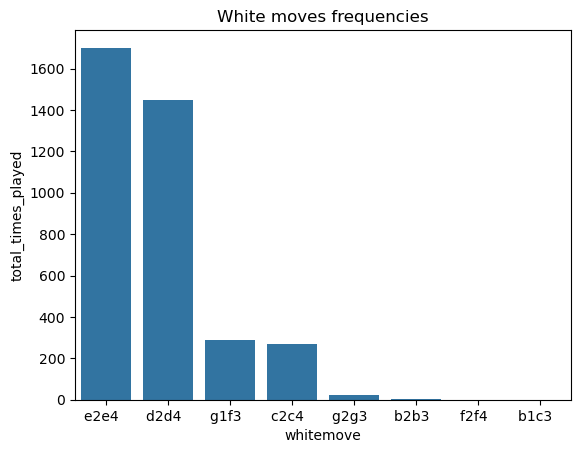

In [180]:
query='SELECT whitemove, SUM(COUNT) AS total_times_played FROM MOVE_MATCH GROUP BY whitemove ORDER BY total_times_played DESC'
df_tot_wh=pd.read_sql_query(query,conn)
sns.barplot(x='whitemove', y='total_times_played', data=df_tot_wh)
plt.title('White moves frequencies')
plt.show()

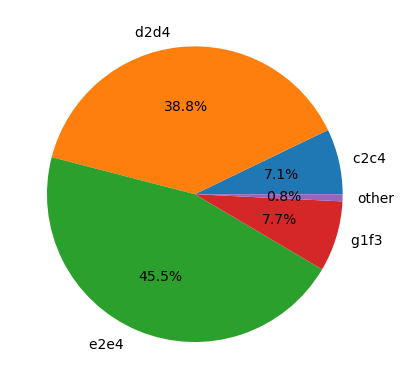

In [112]:
df_tot_wh.loc[df_tot_wh['total_times_played'] < 250, 'whitemove'] = 'other'
fin_df = df_tot_wh.groupby('whitemove', as_index=False)['total_times_played'].sum()
plt.pie(fin_df['total_times_played'], labels=fin_df['whitemove'],  autopct='%1.1f%%')
plt.title('Pie chart of white move percentages')
plt.show()

###  combination of black response to a white move 

In [114]:
%%sql SELECT whitemove, black_move, SUM(count) AS TOTAL_COUNT FROM MOVE_MATCH
GROUP BY whitemove, black_move
ORDER BY (SELECT SUM(COUNT) FROM MOVE_MATCH as mm where MOVE_MATCH.whitemove=mm.whitemove ) DESC, SUM(count) DESC limit 10

 * sqlite:///mydb.db
Done.


whitemove,black_move,TOTAL_COUNT
e2e4,e7e5,661
e2e4,c7c5,618
e2e4,e7e6,175
e2e4,c7c6,162
e2e4,d7d6,41
e2e4,g7g6,16
e2e4,g8f6,13
e2e4,d7d5,11
e2e4,b8c6,2
e2e4,b7b6,2


<Axes: xlabel='whitemove'>

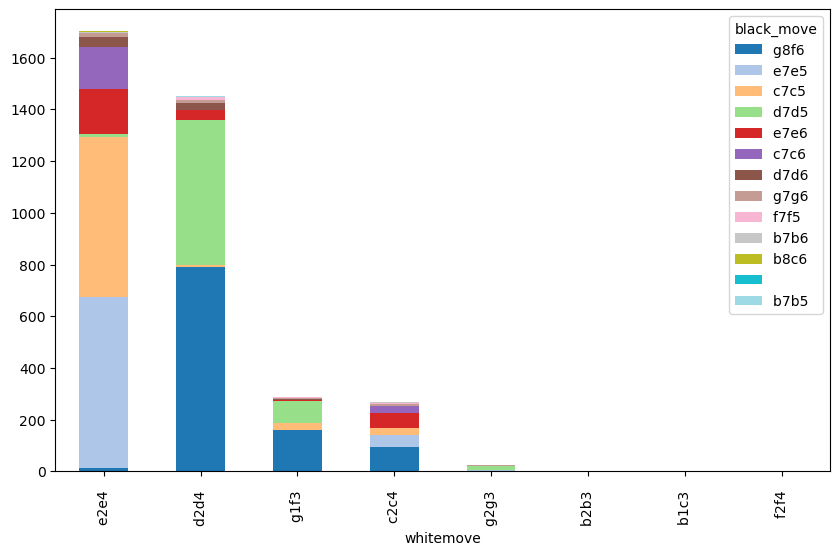

In [82]:
query='''SELECT whitemove, black_move, SUM(count) AS TOTAL_COUNT FROM MOVE_MATCH
GROUP BY whitemove, black_move
ORDER BY (SELECT SUM(COUNT) FROM MOVE_MATCH as mm where MOVE_MATCH.whitemove=mm.whitemove ) DESC, SUM(count) DESC'''
df1=pd.read_sql_query(query,conn)
df_pivot = df1.pivot_table(index='whitemove', columns='black_move', values='TOTAL_COUNT', aggfunc='sum').fillna(0)
df_pivot = df_pivot.loc[df_pivot.sum(axis=1).sort_values(ascending=False).index]
df_pivot = df_pivot[df_pivot.sum(axis=0).sort_values(ascending=False).index]
df_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')


#### Overview of chess opening percentages over time

In [116]:
%sql select * from MOVE_MATCH LIMIT 5

 * sqlite:///mydb.db
Done.


YEAR,player1,player2,whitemove,black_move,champ,COUNT
1886,Steinitz,Zukertort,e2e4,e7e5,Wilhelm Steinitz,11
1886,Steinitz,Zukertort,d2d4,d7d5,Wilhelm Steinitz,9
1889,Steinitz,Chigorin,e2e4,e7e5,Wilhelm Steinitz,9
1889,Steinitz,Chigorin,g1f3,d7d5,Wilhelm Steinitz,6
1889,Steinitz,Chigorin,g1f3,f7f5,Wilhelm Steinitz,1


In [148]:
%%sql select YEAR, whitemove, SUM(COUNT),
SUM(SUM(COUNT)) OVER (PARTITION BY YEAR) AS TOTAL,
ROUND((SUM(COUNT) * 100.0) / SUM(SUM(COUNT)) OVER (PARTITION BY YEAR)) AS percentage
FROM MOVE_MATCH GROUP BY YEAR, whitemove 

 * sqlite:///mydb.db
Done.


YEAR,whitemove,SUM(COUNT),TOTAL,percentage
1886,d2d4,9,20,45.0
1886,e2e4,11,20,55.0
1889,e2e4,9,17,53.0
1889,g1f3,8,17,47.0
1890,d2d4,7,19,37.0
1890,e2e4,8,19,42.0
1890,g1f3,4,19,21.0
1892,e2e4,20,23,87.0
1892,g1f3,3,23,13.0
1894,d2d4,8,19,42.0


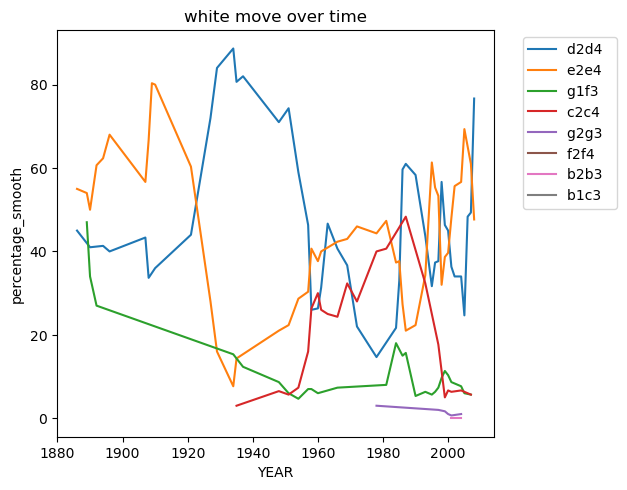

In [172]:
query=''' select YEAR, whitemove, SUM(COUNT),
SUM(SUM(COUNT)) OVER (PARTITION BY YEAR) AS TOTAL,
ROUND((SUM(COUNT) * 100.0) / SUM(SUM(COUNT)) OVER (PARTITION BY YEAR)) AS percentage
FROM MOVE_MATCH GROUP BY YEAR, whitemove'''
dftime=pd.read_sql_query(query,conn)
#I filtered the data to better visualize the change over time
dftime['percentage_smooth'] = dftime.groupby('whitemove')['percentage'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
sns.lineplot(data=dftime, x='YEAR', y='percentage_smooth', hue='whitemove')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # legenda fuori a destra
plt.tight_layout()  
plt.title("white move over time")
plt.show()
